In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import numpy as np
from matplotlib import pyplot as plt

Fix random seed

In [21]:
import random
# Set the seed for Python's built-in random module
random_seed = 42
random.seed(random_seed)

# Set the seed for NumPy
np.random.seed(random_seed)

# Set the seed for PyTorch
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Loading Dataset

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


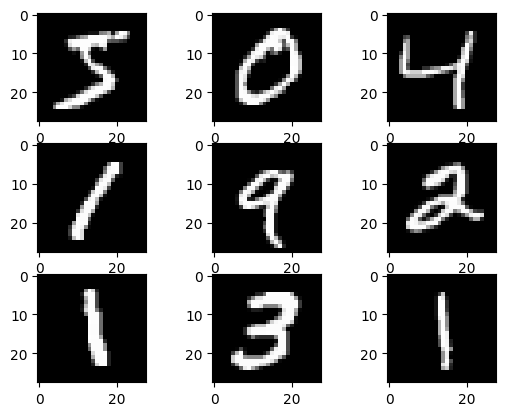

In [3]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
# print shape
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
# plot first few images
for i in range(9):
 plt.subplot(330 + 1 + i)
 plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))

plt.show()

### Preprocessing

In [4]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long

torch_X_train = torch_X_train.view(-1, 1,28,28).float()
torch_X_test = torch_X_test.view(-1,1,28,28).float()
print(torch_X_train.shape)
print(torch_X_test.shape)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)


torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


### Create a CNN Model

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        #10 numbers
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x) #1 -> 32
        x = F.relu(x)

        x = self.conv2(x) #32 -> 32
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv3(x) #32 -> 64
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)

        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


### Fitting model

In [6]:
def fit(model, optimizer, train_loader):
    # Use GPU to train
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    EPOCHS = 20
    model.train()
    loss_values = []

    for epoch in range(EPOCHS):
        correct = 0
        running_loss = 0.0
        total_samples = 0

        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)

            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(output.data, 1)
            total_samples += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        accuracy = correct / total_samples
        epoch_loss = running_loss / len(train_loader)
        loss_values.append(epoch_loss)

        print('[Epoch %d] Loss: %.3f, Accuracy: %.3f' % (epoch + 1, epoch_loss, accuracy))

    return loss_values


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_adam = CNN().to(device)
Adam = torch.optim.Adam(cnn_adam.parameters(), lr=0.001, betas=(0.9, 0.999))
Adam_model = fit(cnn_adam, Adam, train_loader)

[Epoch 1] Loss: 0.496, Accuracy: 0.847
[Epoch 2] Loss: 0.211, Accuracy: 0.939
[Epoch 3] Loss: 0.186, Accuracy: 0.948
[Epoch 4] Loss: 0.180, Accuracy: 0.951
[Epoch 5] Loss: 0.173, Accuracy: 0.953
[Epoch 6] Loss: 0.169, Accuracy: 0.954
[Epoch 7] Loss: 0.164, Accuracy: 0.955
[Epoch 8] Loss: 0.155, Accuracy: 0.959
[Epoch 9] Loss: 0.150, Accuracy: 0.959
[Epoch 10] Loss: 0.150, Accuracy: 0.960
[Epoch 11] Loss: 0.151, Accuracy: 0.960
[Epoch 12] Loss: 0.146, Accuracy: 0.962
[Epoch 13] Loss: 0.142, Accuracy: 0.963
[Epoch 14] Loss: 0.139, Accuracy: 0.964
[Epoch 15] Loss: 0.136, Accuracy: 0.964
[Epoch 16] Loss: 0.134, Accuracy: 0.964
[Epoch 17] Loss: 0.132, Accuracy: 0.965
[Epoch 18] Loss: 0.133, Accuracy: 0.965
[Epoch 19] Loss: 0.135, Accuracy: 0.965
[Epoch 20] Loss: 0.133, Accuracy: 0.965


Training SGD

In [22]:
cnn_sgd = CNN().to(device)
SGD_optimizer = torch.optim.SGD(cnn_sgd.parameters(), lr=0.001)
SGD_model = fit(cnn_sgd, SGD_optimizer, train_loader)

[Epoch 1] Loss: 1.085, Accuracy: 0.636
[Epoch 2] Loss: 0.379, Accuracy: 0.879
[Epoch 3] Loss: 0.274, Accuracy: 0.916
[Epoch 4] Loss: 0.230, Accuracy: 0.929
[Epoch 5] Loss: 0.201, Accuracy: 0.938
[Epoch 6] Loss: 0.178, Accuracy: 0.945
[Epoch 7] Loss: 0.159, Accuracy: 0.952
[Epoch 8] Loss: 0.154, Accuracy: 0.953
[Epoch 9] Loss: 0.141, Accuracy: 0.957
[Epoch 10] Loss: 0.133, Accuracy: 0.960
[Epoch 11] Loss: 0.130, Accuracy: 0.960
[Epoch 12] Loss: 0.122, Accuracy: 0.962
[Epoch 13] Loss: 0.118, Accuracy: 0.963
[Epoch 14] Loss: 0.112, Accuracy: 0.965
[Epoch 15] Loss: 0.107, Accuracy: 0.967
[Epoch 16] Loss: 0.105, Accuracy: 0.968
[Epoch 17] Loss: 0.101, Accuracy: 0.969
[Epoch 18] Loss: 0.096, Accuracy: 0.971
[Epoch 19] Loss: 0.094, Accuracy: 0.971
[Epoch 20] Loss: 0.091, Accuracy: 0.973


Training a couple more popular Alg to compare

Adagrad

In [14]:
cnn_Adagrad = CNN().to(device)
Adagrad = torch.optim.Adagrad(cnn_Adagrad.parameters(), lr=0.001)
Adagrad_model = fit(cnn_Adagrad, Adagrad, train_loader)

[Epoch 1] Loss: 0.784, Accuracy: 0.749
[Epoch 2] Loss: 0.367, Accuracy: 0.885
[Epoch 3] Loss: 0.289, Accuracy: 0.911
[Epoch 4] Loss: 0.251, Accuracy: 0.923
[Epoch 5] Loss: 0.220, Accuracy: 0.932
[Epoch 6] Loss: 0.206, Accuracy: 0.936
[Epoch 7] Loss: 0.189, Accuracy: 0.942
[Epoch 8] Loss: 0.177, Accuracy: 0.944
[Epoch 9] Loss: 0.172, Accuracy: 0.946
[Epoch 10] Loss: 0.161, Accuracy: 0.951
[Epoch 11] Loss: 0.156, Accuracy: 0.952
[Epoch 12] Loss: 0.151, Accuracy: 0.954
[Epoch 13] Loss: 0.145, Accuracy: 0.956
[Epoch 14] Loss: 0.139, Accuracy: 0.957
[Epoch 15] Loss: 0.139, Accuracy: 0.958
[Epoch 16] Loss: 0.133, Accuracy: 0.960
[Epoch 17] Loss: 0.129, Accuracy: 0.960
[Epoch 18] Loss: 0.126, Accuracy: 0.961
[Epoch 19] Loss: 0.124, Accuracy: 0.962
[Epoch 20] Loss: 0.121, Accuracy: 0.963


RMSprop

In [23]:
cnn_RMSprop = CNN().to(device)
RMSprop = torch.optim.RMSprop(cnn_RMSprop.parameters(), lr=0.001)
RMSprop_model = fit(cnn_RMSprop, RMSprop, train_loader)

[Epoch 1] Loss: 0.452, Accuracy: 0.888
[Epoch 2] Loss: 0.184, Accuracy: 0.949
[Epoch 3] Loss: 0.160, Accuracy: 0.957
[Epoch 4] Loss: 0.153, Accuracy: 0.960
[Epoch 5] Loss: 0.159, Accuracy: 0.959
[Epoch 6] Loss: 0.153, Accuracy: 0.961
[Epoch 7] Loss: 0.155, Accuracy: 0.962
[Epoch 8] Loss: 0.156, Accuracy: 0.962
[Epoch 9] Loss: 0.157, Accuracy: 0.960
[Epoch 10] Loss: 0.157, Accuracy: 0.961
[Epoch 11] Loss: 0.165, Accuracy: 0.960
[Epoch 12] Loss: 0.160, Accuracy: 0.961
[Epoch 13] Loss: 0.162, Accuracy: 0.961
[Epoch 14] Loss: 0.165, Accuracy: 0.960
[Epoch 15] Loss: 0.173, Accuracy: 0.961
[Epoch 16] Loss: 0.169, Accuracy: 0.962
[Epoch 17] Loss: 0.186, Accuracy: 0.957
[Epoch 18] Loss: 0.177, Accuracy: 0.960
[Epoch 19] Loss: 0.173, Accuracy: 0.958
[Epoch 20] Loss: 0.187, Accuracy: 0.955


L-BFGS (Approximate Hessian)

In [51]:
cnn_LBFGS = CNN().to(device)
 #use default hyper-parameter (lr=1)


In [52]:
# Use GPU to train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_LBFGS = CNN().to(device)
LBFGS = torch.optim.LBFGS(cnn_LBFGS.parameters())
criterion = nn.CrossEntropyLoss()

def closure():
    LBFGS.zero_grad()
    outputs = cnn_LBFGS(X_batch)
    loss = criterion(outputs, y_batch)
    loss.backward()
    return loss

EPOCHS = 20
cnn_LBFGS.train()
loss_values = []

for epoch in range(EPOCHS):
  correct = 0
  running_loss = 0.0
  total_samples = 0

  for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    lbfgs_optimizer.step(closure)
    running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(output.data, 1)
            total_samples += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        accuracy = correct / total_samples
        epoch_loss = running_loss / len(train_loader)
        loss_values.append(epoch_loss)

        print('[Epoch %d] Loss: %.3f, Accuracy: %.3f' % (epoch + 1, epoch_loss, accuracy))

    return loss_values


LBFGS (
Parameter Group 0
    history_size: 100
    line_search_fn: None
    lr: 1
    max_eval: 25
    max_iter: 20
    tolerance_change: 1e-09
    tolerance_grad: 1e-07
)

Plot Training Loss

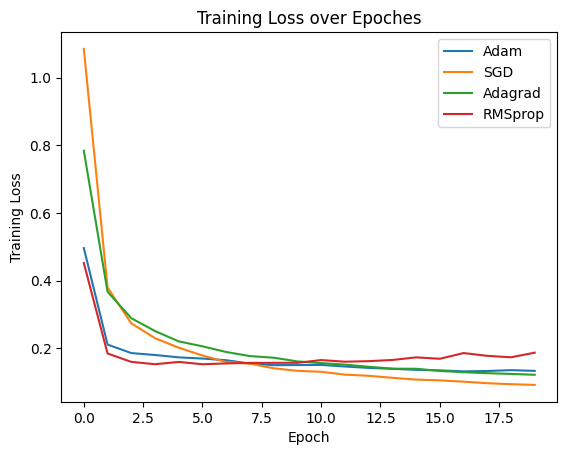

In [48]:
plt.plot(Adam_model, label='Adam')
plt.plot(SGD_model,label='SGD')
plt.plot(Adagrad_model,label='Adagrad')
plt.plot(RMSprop_model,label='RMSprop')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epoches')
plt.legend()
plt.show()

In [45]:
def evaluate(model):
  model.eval()
  correct = 0

  with torch.no_grad():
    for test_imgs, test_labels in test_loader:
        test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
        test_imgs = Variable(test_imgs).float()
        output = model(test_imgs)
        #calculate accuracy
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()

    accuracy = correct / (len(test_loader.dataset))
    print("Accuracy: {:.3f}%".format(accuracy * 100))


In [46]:
evaluate(cnn_adam)


Accuracy: 98.700%


In [47]:
evaluate(cnn_sgd)

Accuracy: 99.120%


In [49]:
evaluate(cnn_RMSprop)

Accuracy: 98.230%


In [50]:
evaluate(cnn_Adagrad)

Accuracy: 98.730%
